# Test custom visualizer

In [1]:
import tensorflow as tf
import pandas as pd
import importlib
import  numpy as np

# Set seed
tf.random.set_seed(42)

import custom_visualizer

## Load data

In [2]:
# Load dataloader
DATASET_PATH = "../processed_data/transformer_dataset"  # adjust if needed

ds = (tf.data.Dataset
      .load(DATASET_PATH)
      .batch(32)
      .prefetch(tf.data.AUTOTUNE))

In [3]:
# def extract_subset_from_dataloader(ds, k, split_id_filter=None, gameId=None, playId=None, frameId=None):
#     """
#     Extract up to `k` examples from the dataset `ds` that match the given filters,
#     supporting batch sizes > 1.

#     Args:
#         ds (tf.data.Dataset): The dataset yielding (ids, X, y) tuples.
#         split_id_filter (int): 0 for train, 1 for val, 2 for test.
#         k (int): Number of items to retrieve (or all if less than k available).
#         gameId (int, optional): Filter by gameId (ids[0]).
#         playId (int, optional): Filter by playId (ids[1]).
#         frameId (int, optional): Filter by frameId (ids[3]).

#     Returns:
#         List of tuples: [(ids, X, y), ...] with up to `k` items matching the filters.
#     """
#     result = []
#     for batch in ds:
#         ids_batch, X_batch, y_batch = batch  # shapes: (B, 4), (B, 100, 46), (B, 46)
#         for i in range(ids_batch.shape[0]):
#             ids = ids_batch[i]
#             if split_id_filter is not None and ids[2].numpy() != split_id_filter:
#                 continue
#             if gameId is not None and ids[0].numpy() != gameId:
#                 continue
#             if playId is not None and ids[1].numpy() != playId:
#                 continue
#             if frameId is not None and ids[3].numpy() != frameId:
#                 continue
#             result.append((
#                 tf.expand_dims(ids, axis=0),             # shape (1, 4)
#                 tf.expand_dims(X_batch[i], axis=0),      # shape (1, 100, 46)
#                 tf.expand_dims(y_batch[i], axis=0),      # shape (1, 46)
#             ))
#             if len(result) == k:
#                 return result
#     return result


In [4]:
# Extract all the sequences from the test set (takes about 3 min)
from custom_visualizer import extract_subset_from_dataloader
test_sequences = extract_subset_from_dataloader(ds, k=None, split_id_filter=2) # 2 for test set
print(f"Number of sequences for test set: {len(test_sequences)}")
print("First sequence:")
test_sequences[0]

Number of sequences for test set: 89920
First sequence:


(<tf.Tensor: shape=(1, 4), dtype=int32, numpy=array([[2022091109,       2481,          2,          1]])>,
 <tf.Tensor: shape=(1, 100, 46), dtype=float32, numpy=
 array([[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.14858334, 0.64596623, 0.1505    , ..., 0.36435273,
          0.1115    , 0.44465292],
         [0.14675   , 0.6553471 , 0.14958334, ..., 0.36210132,
          0.11141667, 0.44465292]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 46), dtype=float32, numpy=
 array([[0.14491667, 0.6643527 , 0.14858334, 0.30731708, 0.12266666,
         0.4664165 , 0.125     , 0.38311446, 0.15683334, 0.27579737,
         0.14233333, 0.554409 

In [5]:
# Drop all sequences in which the first vector has all zeros
old_n = len(test_sequences)
test_sequences = [seq for seq in test_sequences if not np.all(seq[1].numpy()[0, 0] == 0)]
print(f"Number of sequences dropped: {old_n - len(test_sequences)}")
print(f"Number of sequences for test set after dropping all-zero sequences: {len(test_sequences)}")

Number of sequences dropped: 55888
Number of sequences for test set after dropping all-zero sequences: 34032


In [6]:
# Convert the sequences to a DataFrame
from custom_visualizer import covert_sequences_to_df
test_df = covert_sequences_to_df(test_sequences)

test_df.head()

,X,y,gameId,playId,frameId
0,"(((tf.Tensor(0.14858334, shape=(), dtype=float...","((tf.Tensor(0.082166664, shape=(), dtype=float...",2022091109,2481,1
1,"(((tf.Tensor(0.14675, shape=(), dtype=float32)...","((tf.Tensor(0.07958333, shape=(), dtype=float3...",2022091109,2481,2
2,"(((tf.Tensor(0.14491667, shape=(), dtype=float...","((tf.Tensor(0.077083334, shape=(), dtype=float...",2022091109,2481,3
3,"(((tf.Tensor(0.14316666, shape=(), dtype=float...","((tf.Tensor(0.074666664, shape=(), dtype=float...",2022091109,2481,4
4,"(((tf.Tensor(0.14141667, shape=(), dtype=float...","((tf.Tensor(0.072333336, shape=(), dtype=float...",2022091109,2481,5


In [7]:
# Get all the gameIds from the test set
gameIds = test_df['gameId'].unique()
print(f"Number of unique gameIds in the test set: {len(gameIds)}")
print(f"Unique gameIds: {gameIds}")

Number of unique gameIds in the test set: 5
Unique gameIds: [2022091109 2022091108 2022091107 2022091802 2022091900]


In [8]:
# Count the amount of frames per gameId and playId (transform)
test_df['frame_count'] = test_df.groupby(['gameId', 'playId'])['frameId'].transform('count')

# We have to add 100 to the frame count, because the last row has 100 frames in input plust the target
test_df['frame_count'] = test_df['frame_count'] + 100

# Value counts for count
print(test_df['frame_count'].value_counts())

test_df.head()

frame_count
190    720
178    702
186    688
168    680
161    671
      ... 
113     13
109      9
103      6
104      4
101      3
Name: count, Length: 137, dtype: int64


,X,y,gameId,playId,frameId,frame_count
0,"(((tf.Tensor(0.14858334, shape=(), dtype=float...","((tf.Tensor(0.082166664, shape=(), dtype=float...",2022091109,2481,1,170
1,"(((tf.Tensor(0.14675, shape=(), dtype=float32)...","((tf.Tensor(0.07958333, shape=(), dtype=float3...",2022091109,2481,2,170
2,"(((tf.Tensor(0.14491667, shape=(), dtype=float...","((tf.Tensor(0.077083334, shape=(), dtype=float...",2022091109,2481,3,170
3,"(((tf.Tensor(0.14316666, shape=(), dtype=float...","((tf.Tensor(0.074666664, shape=(), dtype=float...",2022091109,2481,4,170
4,"(((tf.Tensor(0.14141667, shape=(), dtype=float...","((tf.Tensor(0.072333336, shape=(), dtype=float...",2022091109,2481,5,170


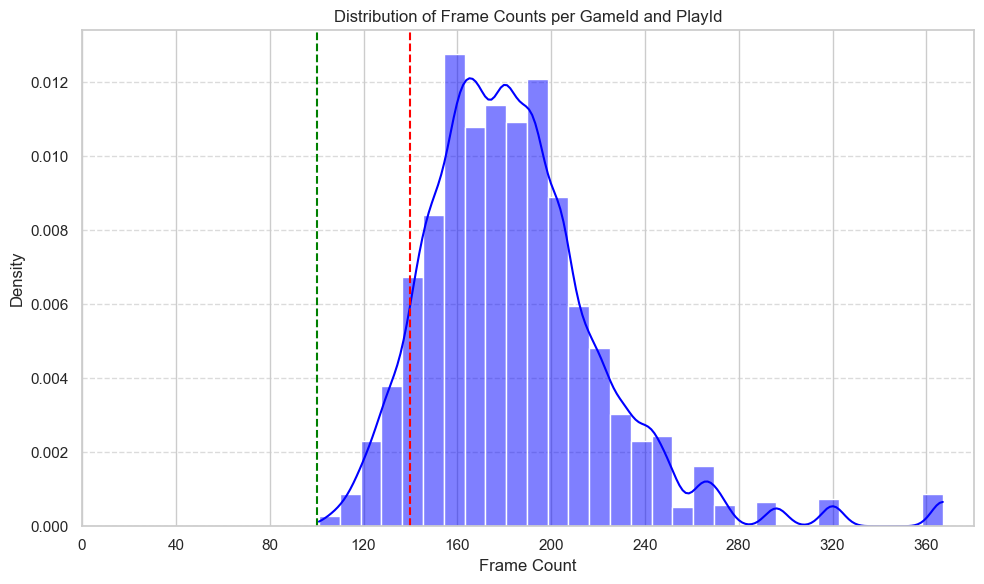

In [9]:
# Plot histogram of frame counts per gameId and playId
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a histogram of the frame counts
plt.figure(figsize=(10, 6))
sns.histplot(test_df['frame_count'], bins=30, kde=True, color='blue', stat='density')
# Vertical line at 140
plt.axvline(x=140, color='red', linestyle='--', label='140 frames')
# Vertical line at 100
plt.axvline(x=100, color='green', linestyle='--', label='100 frames')
plt.title('Distribution of Frame Counts per GameId and PlayId')
plt.xlabel('Frame Count')
plt.ylabel('Density')
plt.xticks(ticks=range(0, test_df['frame_count'].max() + 1, 5))  # Set x-ticks to be integers
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))  # Ensure x-ticks are integers
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [10]:
# Print the number of plays with at least 100 frames
print(f"Number of plays with at least 100 frames: {len(test_df[test_df['frame_count'] >= 100])}", "out of", len(test_df))
print(f"Number of plays with at least 140 frames: {len(test_df[test_df['frame_count'] >= 140])}", "out of", len(test_df))

Number of plays with at least 100 frames: 34032 out of 34032
Number of plays with at least 140 frames: 31350 out of 34032


In [11]:
# Select the frames from one random playId with at least 140 frames
playId = test_df[test_df['frame_count'] >= 140]['playId'].sample(1).values[0]
print(f"Selected playId: {playId}")
play_sequences = test_df[test_df['playId'] == playId]
print(f"Number of sequences for playId {playId}: {len(play_sequences)}")

play_sequences.head()

Selected playId: 62
Number of sequences for playId 62: 51


,X,y,gameId,playId,frameId,frame_count
24119,"(((tf.Tensor(0.22641666, shape=(), dtype=float...","((tf.Tensor(0.26258335, shape=(), dtype=float3...",2022091108,62,1,151
24120,"(((tf.Tensor(0.22791667, shape=(), dtype=float...","((tf.Tensor(0.26258335, shape=(), dtype=float3...",2022091108,62,2,151
24121,"(((tf.Tensor(0.22966667, shape=(), dtype=float...","((tf.Tensor(0.26258335, shape=(), dtype=float3...",2022091108,62,3,151
24122,"(((tf.Tensor(0.23175, shape=(), dtype=float32)...","((tf.Tensor(0.26258335, shape=(), dtype=float3...",2022091108,62,4,151
24123,"(((tf.Tensor(0.234, shape=(), dtype=float32), ...","((tf.Tensor(0.26258335, shape=(), dtype=float3...",2022091108,62,5,151


## Testing

In [12]:
# Print the shape of one observation from train
# (try to get one of the last obsevations)
pct = 0.8
k = int(len(play_sequences) * pct)
print(f"Selected observation: {k}")

one_observation = play_sequences.iloc[k]

print("Shape of one observation from train set:", one_observation.shape)
print("Shape of the first column:", one_observation.iloc[0].shape)
print("Shape of the second column:", one_observation.iloc[1].shape)

# Look at the values from the columns
print("Values from the first column (ids):", one_observation.iloc[0].numpy())
print("Values from the second column (X):", one_observation.iloc[1].numpy())

Selected observation: 40
Shape of one observation from train set: (6,)
Shape of the first column: (1, 100, 46)
Shape of the second column: (1, 46)
Values from the first column (ids): [[[0.25958332 0.55947465 0.25691667 ... 0.15478425 0.26558334 0.55797374]
  [0.2595     0.55947465 0.25691667 ... 0.15234521 0.26558334 0.55797374]
  [0.2595     0.55909944 0.257      ... 0.15009381 0.26558334 0.5577861 ]
  ...
  [0.274      0.48968107 0.26383334 ... 0.17148218 0.25133333 0.49305817]
  [0.27508333 0.4878049  0.26516667 ... 0.1750469  0.25433335 0.484803  ]
  [0.276      0.48555347 0.2665     ... 0.17917448 0.25733334 0.4761726 ]]]
Values from the second column (X): [[0.27691665 0.48292682 0.26766667 0.46435273 0.322      0.17767355
  0.26041666 0.46791744 0.234      0.6210131  0.2545     0.58273923
  0.2995     0.3639775  0.27091667 0.51125705 0.26741666 0.48761725
  0.26216668 0.39118198 0.26       0.52664167 0.25741667 0.3968105
  0.41666666 0.43621013 0.25566667 0.48517823 0.28241667 0.

(<Figure size 1200x670 with 1 Axes>, <Axes: >)

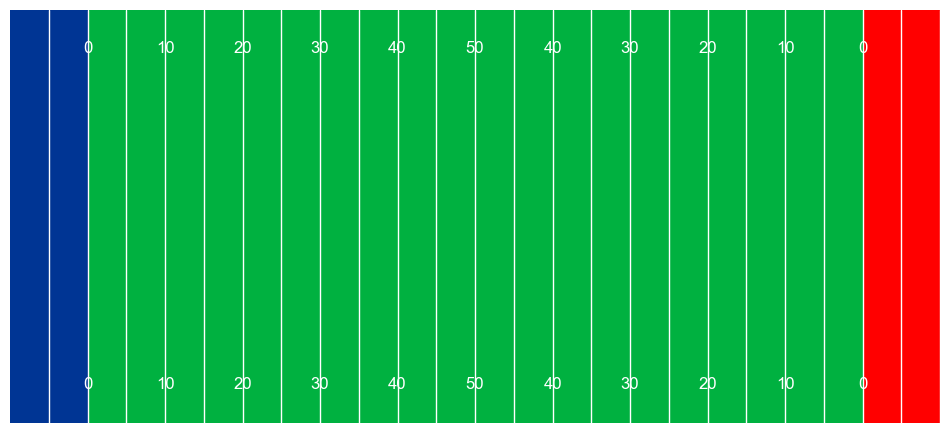

In [13]:
# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

custom_visualizer.plot_pitch()

In [14]:
# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

# Test function to extract the trajectory of one player
input_coordinates = one_observation.X[0]

traj = custom_visualizer.extract_player_trajectory(input_coordinates, 'offense', player_index=7)
traj

<tf.Tensor: shape=(100, 2), dtype=float32, numpy=
array([[0.25383332, 0.61688554],
       [0.25383332, 0.6166979 ],
       [0.25375   , 0.61651033],
       [0.25366667, 0.61613506],
       [0.25366667, 0.6159475 ],
       [0.25366667, 0.61575985],
       [0.25366667, 0.61575985],
       [0.25366667, 0.6155722 ],
       [0.25375   , 0.6155722 ],
       [0.25383332, 0.615197  ],
       [0.254     , 0.6148218 ],
       [0.25408334, 0.61463416],
       [0.25425   , 0.6142589 ],
       [0.25433335, 0.6138837 ],
       [0.25441667, 0.61350846],
       [0.2545    , 0.61350846],
       [0.25458333, 0.61350846],
       [0.25466666, 0.61369604],
       [0.25466666, 0.61369604],
       [0.25475   , 0.61369604],
       [0.25491667, 0.61350846],
       [0.25508332, 0.6138837 ],
       [0.25516668, 0.6140713 ],
       [0.25525   , 0.6140713 ],
       [0.25541666, 0.6142589 ],
       [0.2555    , 0.6140713 ],
       [0.25566667, 0.6142589 ],
       [0.25566667, 0.6140713 ],
       [0.25566667, 0.6142

In [15]:
# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

# Test descaling function
input_coordinates = one_observation.X[0]

traj = custom_visualizer.extract_player_trajectory(input_coordinates, 'offense', player_index=7)
traj = custom_visualizer.descale_trajectory(traj)
traj

<tf.Tensor: shape=(100, 2), dtype=float32, numpy=
array([[30.46    , 32.879997],
       [30.46    , 32.87    ],
       [30.449999, 32.86    ],
       [30.44    , 32.84    ],
       [30.44    , 32.83    ],
       [30.44    , 32.82    ],
       [30.44    , 32.82    ],
       [30.44    , 32.809998],
       [30.449999, 32.809998],
       [30.46    , 32.79    ],
       [30.480001, 32.77    ],
       [30.49    , 32.76    ],
       [30.509998, 32.739998],
       [30.520002, 32.72    ],
       [30.53    , 32.7     ],
       [30.54    , 32.7     ],
       [30.55    , 32.7     ],
       [30.56    , 32.71    ],
       [30.56    , 32.71    ],
       [30.570002, 32.71    ],
       [30.59    , 32.7     ],
       [30.609999, 32.72    ],
       [30.62    , 32.73    ],
       [30.630001, 32.73    ],
       [30.65    , 32.739998],
       [30.659998, 32.73    ],
       [30.68    , 32.739998],
       [30.68    , 32.73    ],
       [30.68    , 32.739998],
       [30.69    , 32.739998],
       [30.699999, 3

(<Figure size 1200x670 with 1 Axes>, <Axes: >)

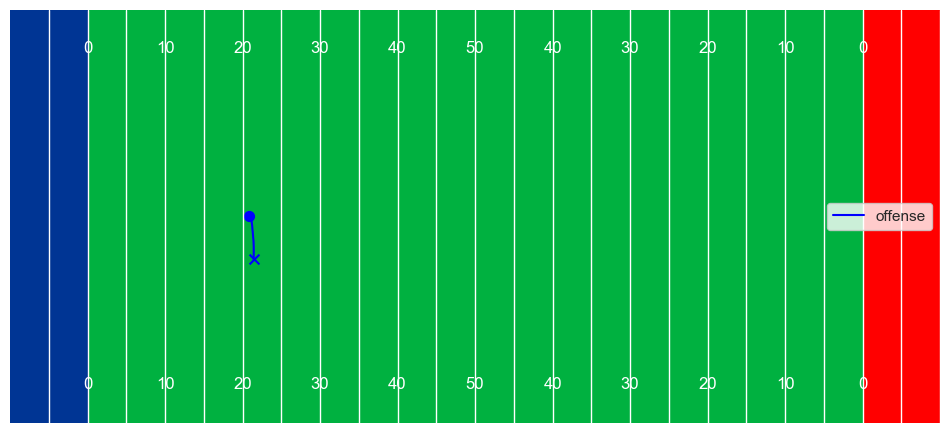

In [16]:
# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

# Test plot_player_trajectory function
input_coordinates = one_observation.X[0]

traj = custom_visualizer.extract_player_trajectory(input_coordinates, 'offense', player_index=9)
traj = custom_visualizer.descale_trajectory(traj)
# print(traj)

custom_visualizer.plot_player_trajectory(traj, traj_label='offense')

(<Figure size 1200x670 with 1 Axes>, <Axes: >)

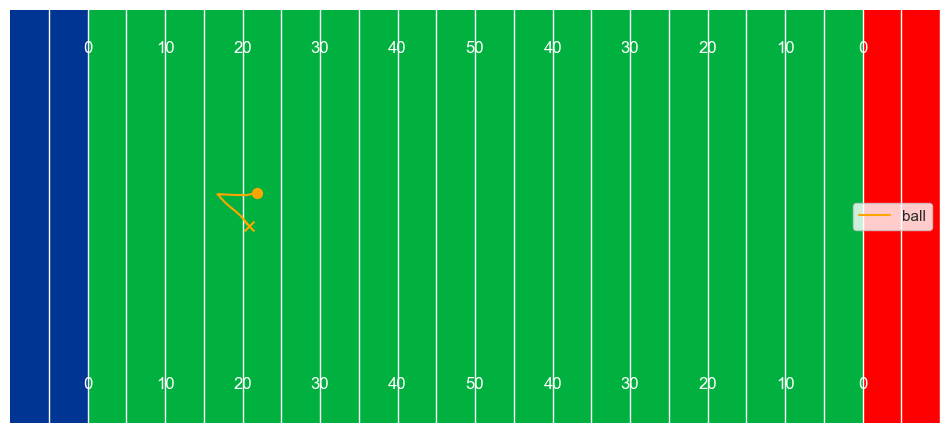

In [17]:
# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

# Test plot_player_trajectory function
input_coordinates = one_observation.X[0]

traj = custom_visualizer.extract_player_trajectory(input_coordinates, team='ball', player_index=9)
traj = custom_visualizer.descale_trajectory(traj)
# print(traj)

custom_visualizer.plot_player_trajectory(traj, traj_label='ball')

(<Figure size 1200x670 with 1 Axes>, <Axes: >)

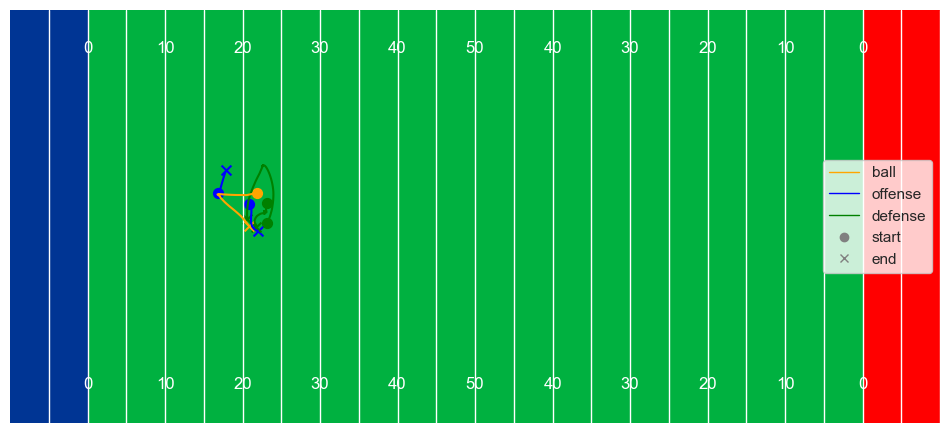

In [18]:
# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

# Test function to plot trajectories of multiple players at once
input_coordinates = one_observation.X[0]

custom_visualizer.plot_trajectories(input_coordinates, offense=[1,4], defense=[2,5], include_ball=True)

(<Figure size 1200x670 with 1 Axes>, <Axes: >)

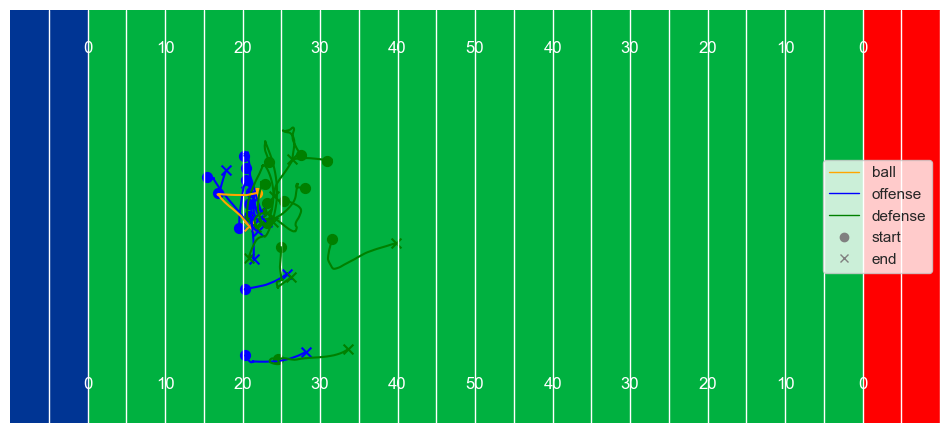

In [19]:
# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

# Test function to plot trajectories of multiple players at once
input_coordinates = one_observation.X[0]

custom_visualizer.plot_trajectories(input_coordinates, offense='all', defense='all', include_ball=True)

## Now full trajectories
Now let's try making a differnce between input, ground truth and predicted

In [20]:
from custom_visualizer import extract_full_sequence

In [21]:
full_X = extract_full_sequence(play_sequences)
print(full_X.shape)   # → (1, #frames_in_play, 46)

(1, 151, 46)


(1, 151, 46)


(<Figure size 1200x670 with 1 Axes>, <Axes: >)

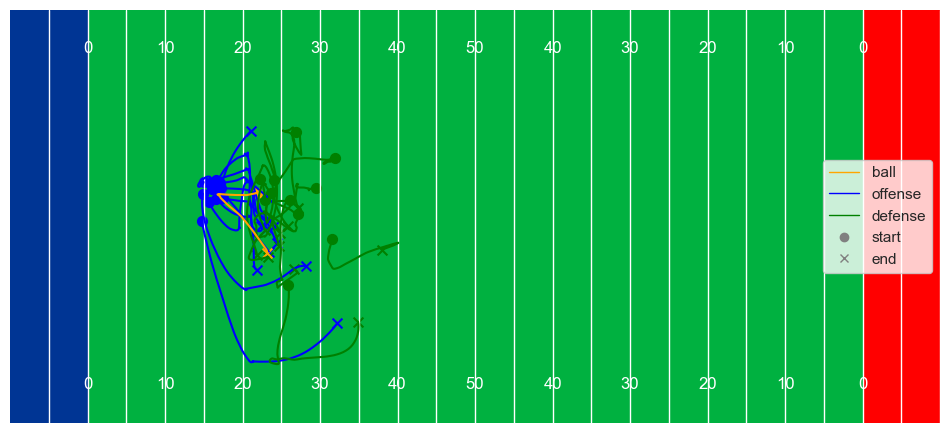

In [22]:
# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

# Test function to plot trajectories of multiple players at once
full_X = extract_full_sequence(play_sequences)
print(full_X.shape)   # → (1, #frames_in_play, 46)

custom_visualizer.plot_trajectories(full_X, offense='all', defense='all', include_ball=True)


Selected playId: 1266
Number of sequences for playId 1266: 40
(1, 140, 46)


(<Figure size 1200x670 with 1 Axes>, <Axes: >)

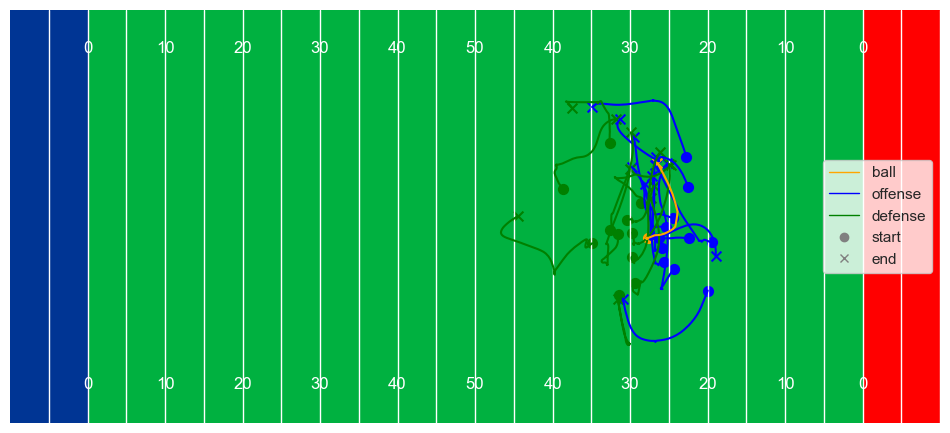

In [23]:
# Try a different play

# Select the frames from one random playId with at least 140 frames
playId = test_df[test_df['frame_count'] >= 140]['playId'].sample(1).values[0]
print(f"Selected playId: {playId}")
play_sequences2 = test_df[test_df['playId'] == playId]
print(f"Number of sequences for playId {playId}: {len(play_sequences2)}")

# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

# Test function to plot trajectories of multiple players at once
full_X = extract_full_sequence(play_sequences2)
print(full_X.shape)   # → (1, #frames_in_play, 46)

custom_visualizer.plot_trajectories(full_X, offense='all', defense='all', include_ball=True)

Selected playId: 2541
Number of sequences for playId 2541: 85
(1, 185, 46)
(1, 85, 46)
First 2 values of first_X: tf.Tensor(
[[0.57475    0.53958726]
 [0.574      0.5393996 ]], shape=(2, 2), dtype=float32)
First 2 values of pred: tf.Tensor(
[[0.61125   0.5766417]
 [0.61125   0.5766417]], shape=(2, 2), dtype=float32)


(<Figure size 1200x670 with 1 Axes>, <Axes: >)

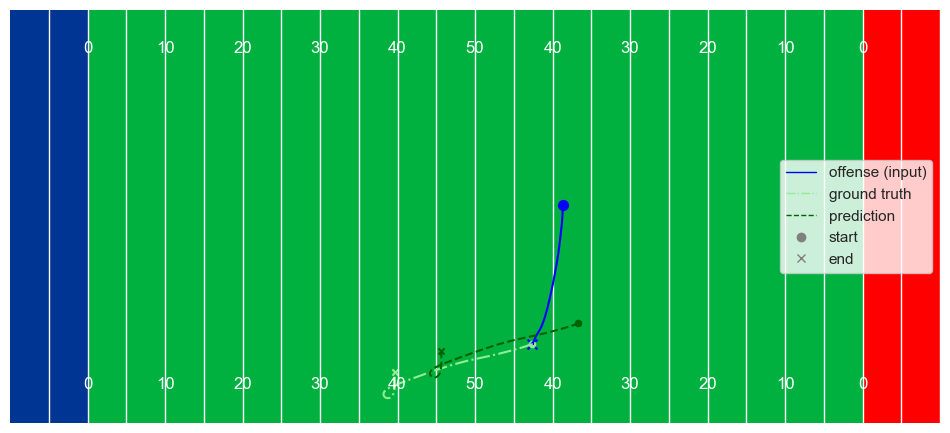

In [24]:
# Select the frames from one random playId with at least 140 frames
playId = 2541
print(f"Selected playId: {playId}")
play_sequences2 = test_df[test_df['playId'] == playId]
print(f"Number of sequences for playId {playId}: {len(play_sequences2)}")

# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

full_X = extract_full_sequence(play_sequences2)
print(full_X.shape)

# Get the first 100 frames from full_X
first_X = full_X[:, :100, :]
# Get the subsequent frames until the end
subsequent_X = full_X[:, 100:, :]
# Simulate subsequent_X with some noise (just add 0.1 to each value)
offset = 0.05
pred = subsequent_X + tf.fill(subsequent_X.shape, offset)
print(pred.shape) 

# Print first 2 values of first_X and pred
print("First 2 values of first_X:", first_X[0, :2, :2])
print("First 2 values of pred:", pred[0, :2, :2])

custom_visualizer.plot_trajectories(
    sequence=first_X,
    offense=[10],
    ground_truth_seq=subsequent_X,
    pred_seq=pred,
    include_ball=False
)

Selected playId: 4117
Number of sequences for playId 4117: 58
(1, 158, 46)
(1, 58, 46)
First 2 values of first_X: tf.Tensor(
[[0.39316666 0.4596623 ]
 [0.39216667 0.4598499 ]], shape=(2, 2), dtype=float32)
First 2 values of pred: tf.Tensor(
[[0.40758336 0.51998127]
 [0.40758336 0.51998127]], shape=(2, 2), dtype=float32)


(<Figure size 1200x670 with 1 Axes>, <Axes: >)

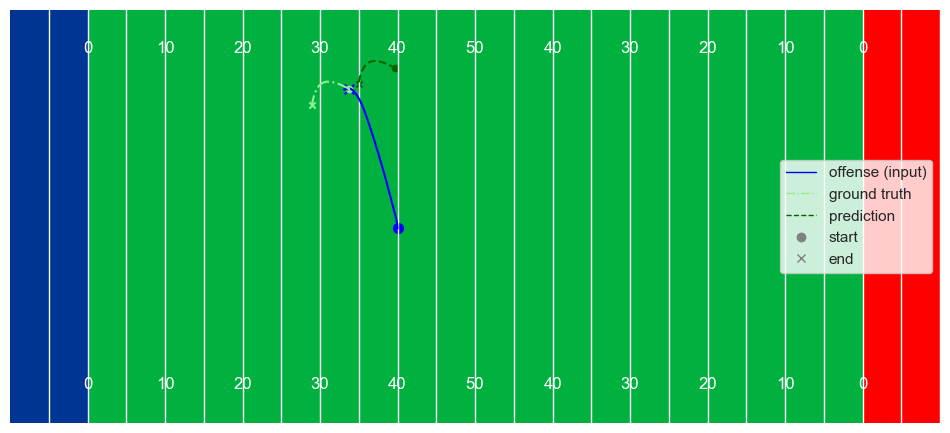

In [25]:
# Select the frames from one random playId with at least 140 frames
playId = test_df[test_df['frame_count'] >= 140]['playId'].sample(1).values[0]
print(f"Selected playId: {playId}")
play_sequences2 = test_df[test_df['playId'] == playId]
print(f"Number of sequences for playId {playId}: {len(play_sequences2)}")

# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

full_X = extract_full_sequence(play_sequences2)
print(full_X.shape)

# Get the first 100 frames from full_X
first_X = full_X[:, :100, :]
# Get the subsequent frames until the end
subsequent_X = full_X[:, 100:, :]
# Simulate subsequent_X with some noise (just add 0.1 to each value)
offset = 0.05
pred = subsequent_X + tf.fill(subsequent_X.shape, offset)
print(pred.shape) 

# Print first 2 values of first_X and pred
print("First 2 values of first_X:", first_X[0, :2, :2])
print("First 2 values of pred:", pred[0, :2, :2])

custom_visualizer.plot_trajectories(
    sequence=first_X,
    offense=[10],
    ground_truth_seq=subsequent_X,
    pred_seq=pred,
    include_ball=False
)

Selected playId: 697
Number of sequences for playId 697: 133
(1, 233, 46)
First 2 values of first_X: tf.Tensor(
[[0.7058333 0.5401501]
 [0.7058333 0.5405253]], shape=(2, 2), dtype=float32)
First 2 values of pred: tf.Tensor(
[[0.6977913  0.5552929 ]
 [0.69615966 0.5497651 ]], shape=(2, 2), dtype=float32)


(<Figure size 1200x670 with 1 Axes>, <Axes: >)

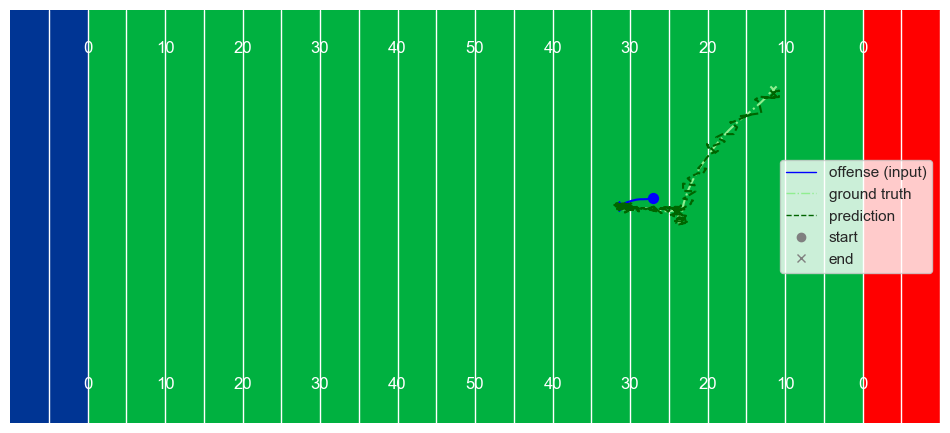

In [26]:
# Select the frames from one random playId with at least 140 frames
playId = test_df[test_df['frame_count'] >= 140]['playId'].sample(1).values[0]
print(f"Selected playId: {playId}")
play_sequences2 = test_df[test_df['playId'] == playId]
print(f"Number of sequences for playId {playId}: {len(play_sequences2)}")

# reload the module to ensure the latest version is used
importlib.reload(custom_visualizer)

full_X = extract_full_sequence(play_sequences2)
print(full_X.shape)

# Get the first 100 frames from full_X
first_X = full_X[:, :100, :]
# Get the subsequent frames until the end
subsequent_X = full_X[:, 100:, :]
# Add very small random noise around zero
noise_scale = 0.01  # much smaller noise
noise = tf.random.uniform(subsequent_X.shape, minval=-noise_scale, maxval=noise_scale)

# Simulated prediction: ground truth + small noise
pred = subsequent_X + noise

# Print first 2 values of first_X and pred
print("First 2 values of first_X:", first_X[0, :2, :2])
print("First 2 values of pred:", pred[0, :2, :2])

custom_visualizer.plot_trajectories(
    sequence=first_X,
    offense=[1],
    ground_truth_seq=subsequent_X,
    pred_seq=pred,
    include_ball=False
)